# MME Plotting

### Description:
We will be looking at the four largest ensembles, calculating their gradient trends and then seeing where observations lie within those ranges. Additionally, we will be quantifying where the observations lie within those ranges (i.e., ascertaining whether the models are struggling more to encompass these trends with time

### Structure:
#### This code:
Second part of the code will read in observational data  
Third part of the code will read back in the model trend data and compare it with observations, including plotting  
Fourth part will calcluate MME mean for the models and also plot this  
Fifth part will calculate the universal 95% range of the models and plot observations relative to this  
Sixth part of the code calculates two metrics that may be predictive of model ability to capture observations

#### Other codes:
Initial part of the code will be for selecting and running the models; output in the form of gradients and trends will be saved to a directory  

### Notes:  
I am not fixing the scenario historical matching here as it appears that's fine for the four model subset

In [222]:
%reset -f

In [223]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [224]:
%reload_ext autoreload
%autoreload 2

In [225]:
# analysis functions
import xarray as xr
import numpy as np
import pandas as pd
from scipy.stats import percentileofscore

# plotting functions
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns

# systems functions
import os
from collections import defaultdict
from datetime import date

# my own classes and functions
from GradTrendClasses import ModelInput, Trend, TrendPlotting, CalculateMMEGradient, CalculateObsGradient, Gradient
from GradientProjectFunctions import CropTrendsDf, RemoveClimatology, DictToDf, TrendsDictFromFiles, CalculateTrendPercentile, FlagInRange, ClassifyModels
from GradientProjectFunctions import CalculateModelRange, CalculateObsPercentile, CreateScenarioDictionary, ExtendPeriod, ConcatModels, ClassifyHistModelsLite

## Setting up directory and file names

#### Outputs

In [226]:
#______Trends and Gradients________
pathBase = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/'
#trendsDirEnd = 'Trends_' + str(date.today())
trendsDirEnd = 'Trends_MASTER'
#gradientsDirEnd = 'Gradients_' + str(date.today())
gradientsDirEnd = 'Gradients_MASTER'

trendsDir = pathBase + trendsDirEnd
gradientsDir = pathBase + gradientsDirEnd

#_____Plots________
pathBase = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/'
plotsEnd = 'Plots_MASTER'

plotsDir = pathBase + plotsEnd

#### Inputs

In [227]:
#_____Hadley___________
obsDir = '/home/hbyrne/Research/QMDA_2023'

# inputting from a csv file
openDapDir = '/home/hbyrne/Research/Gradient_project/OpenDap_inputs'

#____Stats______
statsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Model_Statistics'

## 2) Reading in the observational data

In [228]:
fileName = 'HadISST_sst 2.nc'
os.chdir(obsDir)

In [229]:
# running the classes on it
modelInput = ModelInput(fileName)

# have to roll the coordinates for Hadley
modelInput = modelInput.ds.assign_coords(lon = ((360 + (modelInput.ds.lon % 360)) % 360))
modelInput = modelInput.roll(lon = int(len(modelInput['lon']) / 2), roll_coords = True)

# remove climatology
modelInput = RemoveClimatology(modelInput)

# calculate the gradient
gradient = CalculateObsGradient(modelInput, 'HadleyISST')

# calculate the trend
trendsHad = Trend(gradient).trends
trendsHadDf = Trend(gradient).trendsDf

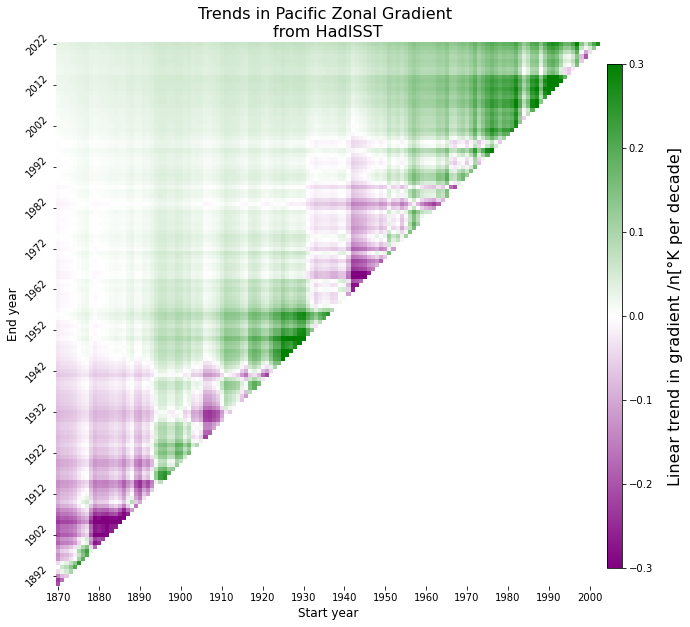

In [230]:
# the Had data has end dates that start at 1870 and start dates up to 2022; cropping so that we don't include those in the plot
# cropping the trends Df so that plotting doesn't include deadspace
offset = 20 # years
trendsHadDf = CropTrendsDf(trendsHadDf, offset)

# calculate the vmin and vmax
vmin = trendsHadDf.min().min()
vmax = trendsHadDf.max().max()

# find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
if (vmin < 0) & (vmax > 0):
    limit = max(abs(vmin), abs(vmax))
    vmin = -limit
    vmax = limit
    
vmin = -0.3
vmax = -vmin
    
# setting the colorbar
colors = [(0,'purple'), (0.50,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

# plotting the figure
fig = plt.figure(figsize = (10,10))
axesList = []

ax = fig.add_subplot(111)
ax.set_aspect('equal')
trendPlotter = TrendPlotting(trendsHadDf, 'Trends in Pacific Zonal Gradient \nfrom HadISST', vmin, vmax, cmap, norm)
plot = trendPlotter.PlotTrends(ax)  
axesList.append(ax)

cbarAx = fig.add_axes([0.9, 0.15, 0.02, 0.7])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('Linear trend in gradient /n[°K per decade]', rotation = 90, labelpad = 15, fontsize = 16)

# saving the figure
# making and changing the directory
if os.path.isdir(plotsDir):
    os.chdir(plotsDir)
else:
    os.mkdir(plotsDir)
    os.chdir(plotsDir)

fileName = 'Hadley.png'
plt.savefig(fileName)

plt.show()

## 3) Read back in the trend data and calculate the 95% interval

Adding in functionality here, per Jason and Richard:  
Percentile where the observation lies  
Variance for each (maybe difference between 95% and 5%)

In [421]:
# read in the model summary for ordering

os.chdir(statsDir)
modelSummary = pd.read_csv('ModelSummaries.csv', index_col=0)

# now order them according to one of the metrics and pull out the indices
models = list(modelSummary.sort_values(by = 'CorrHad', ascending = False).index)

In [422]:
print(models)

['MPI-ESM1-2-LR', 'CNRM-CM6-1', 'IPSL-CM6A-LR', 'ACCESS-ESM1-5', 'CanESM5', 'GISS-E2-1-G', 'MIROC6', 'MIROC-ES2L']


MPI-ESM1-2-LR complete
CNRM-CM6-1 complete
IPSL-CM6A-LR complete
ACCESS-ESM1-5 complete
CanESM5 complete
GISS-E2-1-G complete
MIROC6 complete
MIROC-ES2L complete


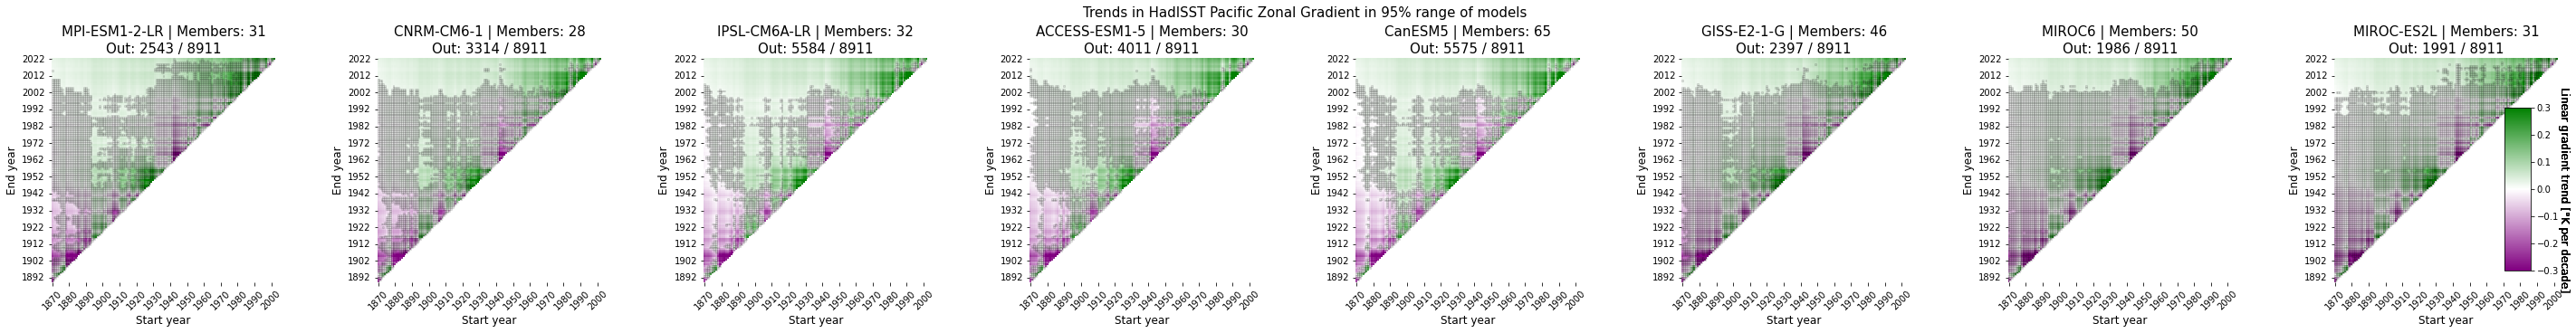

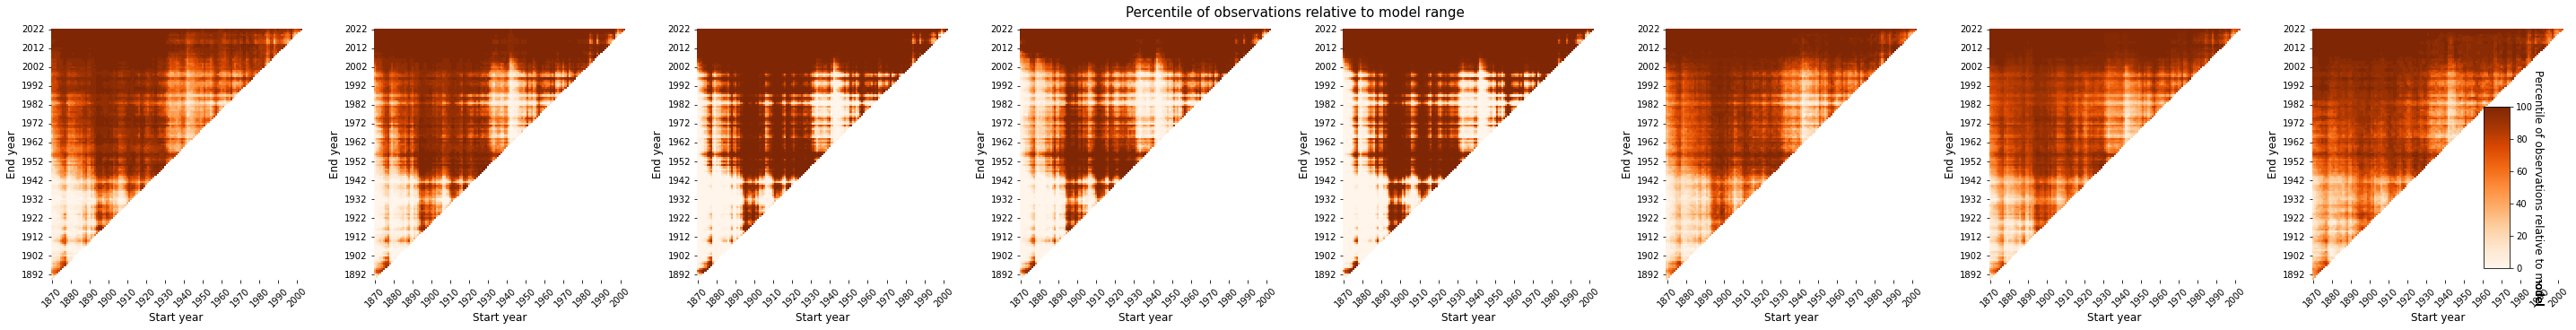

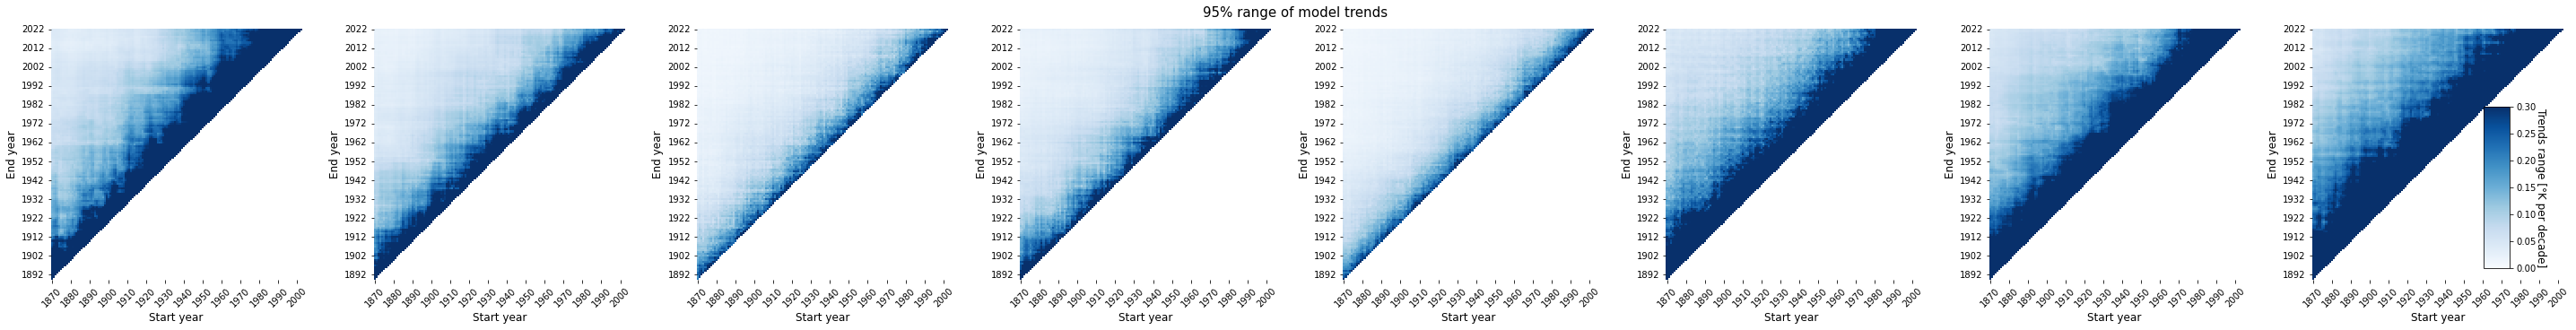

In [423]:
os.chdir(trendsDir)

# model names so it can loop through and just select those models
#models = ['CanESM5', 'MIROC6', 'GISS-E2-1-G', 'MPI-ESM1-2-LR', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'ACCESS-ESM1-5', 'CNRM-CM6-1']

# establishing some dictionaries to hold universal values (for now just universal 95% and 5% for all models)
dictLowerUni = defaultdict(list)
dictUpperUni = defaultdict(list)
trendsUni = defaultdict(list)
dictRanges = {}
dictPercentIn = {}
dictMembersNum = {}
dictObsInRangeAll = {}

# ___Plotting Figures____

# __Universal attributes___
nFigures = len(models)
nCols = nFigures

if nFigures % nCols == 0:
    nRows = int(nFigures/nCols)
else:
    nRows = int(np.floor(nFigures/nCols) + 1)

subplotSize = (5, 5)
figWidth = nCols * subplotSize[0]
figHeight = nRows * subplotSize[1]


# ___Obs in Range____

# create the axes list
axesList = []

# create the figure
fig1 = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig1.suptitle('Trends in HadISST Pacific Zonal Gradient in 95% range of models', fontsize = 15)

# ___Obs percentile___
fig2 = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig2.suptitle('Percentile of observations relative to model range', fontsize = 15)

# __Model range___
fig3 = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig3.suptitle('95% range of model trends', fontsize = 15)


for i, model in enumerate(models):
    
    # create a dictionary with all of the trends from this directory
    trendsDict = TrendsDictFromFiles(trendsDir, model)
    trendsUni[model].append(trendsDict)
    
    # count the number of models
    memberCount = len(trendsDict[1870,2022])
    dictMembersNum[model] = memberCount
    
    # create dictionaries with lower and upper percentiles from the distribution of trends
    dictLower, dictUpper = CalculateTrendPercentile(trendsDict, 2.5, 97.5)
    
    # saving these values to the universal dictionaries (entire dictionaries where each main key is the model name)
    dictLowerUni[model] = dictLower
    dictUpperUni[model] = dictUpper

    # flagging everywhere that the values lie within the range of the models
    dictObsInRange = FlagInRange(dictLower, dictUpper, trendsHad)
    
    # counting the number of grid points inside
    countOut = list(dictObsInRange.values()).count(0)
    countTotal = list(dictObsInRange.values()).count(1)+list(dictObsInRange.values()).count(0)
    dictPercentIn[model] = (countTotal - countOut)/countTotal

    # creating a dataframe for the ObsInRange
    dfObsInRange = DictToDf(dictObsInRange)

    # removing the bottom 20 rows so that this stippling df has the same dimensions as the observations
    keepRows = [row for row in dfObsInRange.index if row >= 1890]
    dfObsInRange = dfObsInRange.loc[keepRows, :]
    dictObsInRangeAll[model] = dfObsInRange
    
    # calculating obs percentile
    dfObsPercentile = CalculateObsPercentile(trendsDict, trendsHad)
    
    # calculating total range
    dfRange = CalculateModelRange(dictLower, dictUpper)
    dictRanges[model] = dfRange
    
    # plotting
    
    #___OBS IN RANGE___

    # calculate the vmin and vmax
    vmin = trendsHadDf.min().min()
    vmax = trendsHadDf.max().max()

    # find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
    if (vmin < 0) & (vmax > 0):
        limit = max(abs(vmin), abs(vmax))
        vmin = -limit
        vmax = limit

    vmin = -0.3
    vmax = -vmin

    # setting the colorbar
    colors = [(0,'purple'), (0.50,'white'), (1,'green')]
    cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
    norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

    ax = fig1.add_subplot(nRows, nCols, i+1)
    ax.set_aspect('equal')
    ax.set_title(f'{model} | Members: {memberCount}\nOut: {countOut} / {countTotal}', fontsize = 15)
    plot = sns.heatmap(trendsHadDf, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, center = 0, cbar = False, norm = norm)
    ax.tick_params(axis = 'x', rotation = 45)
    ax.tick_params(axis = 'y', rotation = 0)
    ax.set_ylabel('End year', fontsize = 12)
    ax.set_xlabel('Start year', fontsize = 12)

    cbarAx = fig1.add_axes([0.96, 0.18, 0.01, 0.5])
    colorBar = fig1.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('Linear gradient trend [°K per decade]', rotation = 270, labelpad = 12, fontsize = 12)

    # adding the stippling with a for loop
    for a, row in enumerate(dfObsInRange.values):
        for b, value in enumerate(row):
            if value == 1:
                plot.add_patch(plt.Rectangle((b, a), 1, 1, fill=True, color = 'black', edgecolor=None, alpha = 0.1))
                
    #___OBS PERCENTILE___
    # set max and min though they will always be the same
    vmin = 0
    vmax = 100

    # setting the colorbar
    cmap = 'Oranges'
    norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

    ax = fig2.add_subplot(nRows, nCols, i+1)
    ax.set_aspect('equal')
    #ax.set_title(f'{model}', fontsize = 15)
    plot = sns.heatmap(dfObsPercentile, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
    ax.tick_params(axis = 'x', rotation = 45)
    ax.tick_params(axis = 'y', rotation = 0)
    ax.set_ylabel('End year', fontsize = 12)
    ax.set_xlabel('Start year', fontsize = 12)

    cbarAx = fig2.add_axes([0.96, 0.18, 0.01, 0.5])
    colorBar = fig2.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('Percentile of observations relative to model', rotation = 270, labelpad = 12, fontsize = 12)
    
    #___OBS RANGE___
    
    vmin = 0
    vmax = 0.3 # Note that these values were selected after running it once and looking at the max and min of the whole spread; have to be changed manually
    
    # setting the colorbar
    cmap = 'Blues'
    norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

    ax = fig3.add_subplot(nRows, nCols, i+1)
    ax.set_aspect('equal')    
    #ax.set_title(f'{model}', fontsize = 15)
    plot = sns.heatmap(dfRange, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
    ax.tick_params(axis = 'x', rotation = 45)
    ax.tick_params(axis = 'y', rotation = 0)
    ax.set_ylabel('End year', fontsize = 12)
    ax.set_xlabel('Start year', fontsize = 12)

    cbarAx = fig3.add_axes([0.96, 0.18, 0.01, 0.5])
    colorBar = fig3.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('Trends range [°K per decade]', rotation = 270, labelpad = 12, fontsize = 12)
    
    print(f'{model} complete')

# saving the figures
# making and changing the directory
if os.path.isdir(plotsDir):
    os.chdir(plotsDir)
else:
    os.mkdir(plotsDir)
    os.chdir(plotsDir)

fileName = 'Model_summaries_ALL'

for i, fig in enumerate(plt.get_fignums()):
    plt.figure(fig)
    plt.savefig(f'{fileName}_{i}.png')

plt.show()

## 4) Calculating the mean

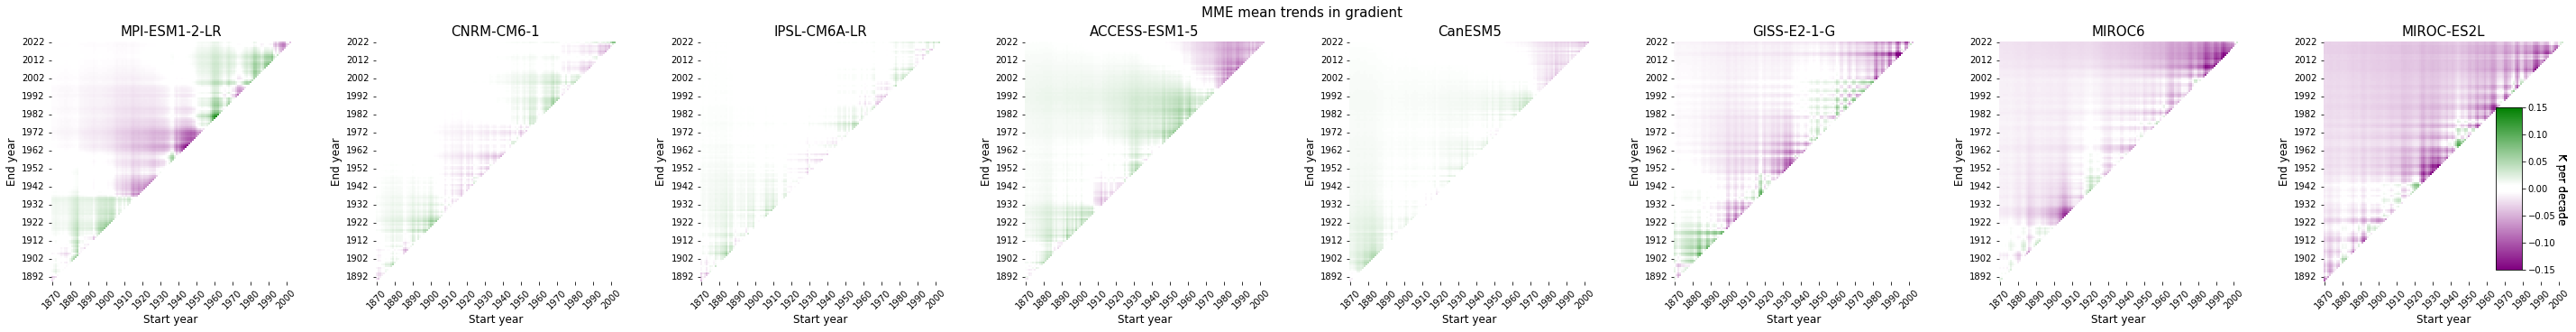

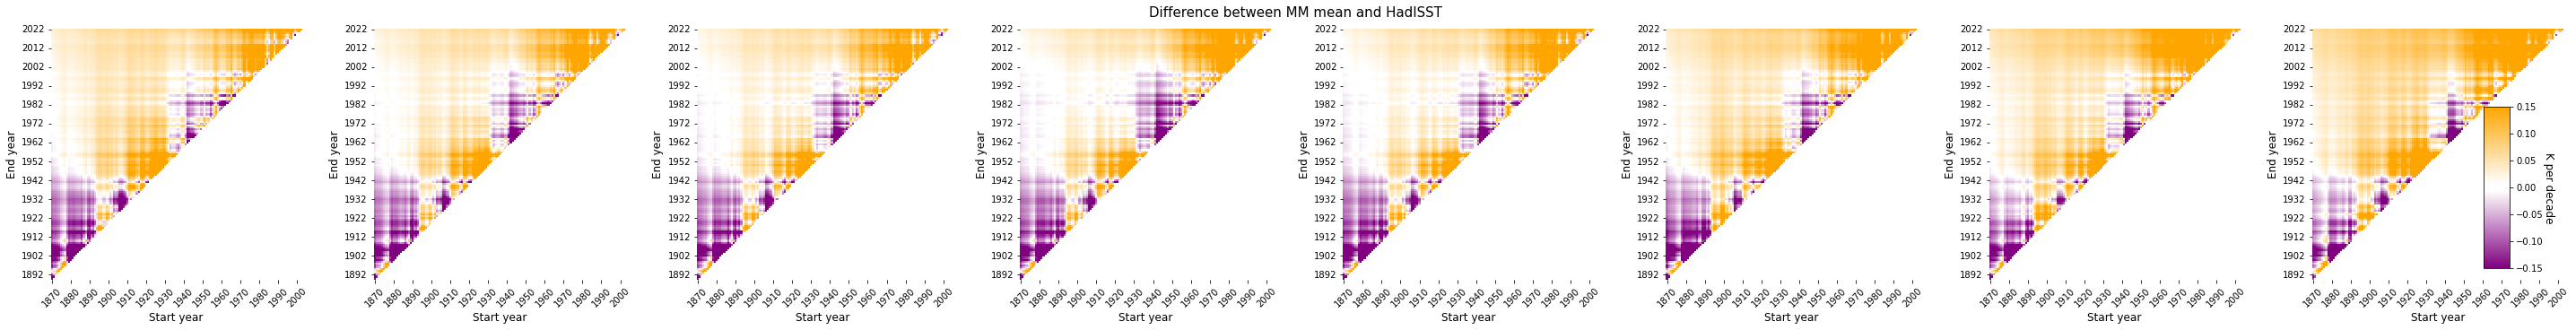

In [424]:
# gradientsDir = '/home/hbyrne/Research/Gradient_project/gradient_project/Outputs/Gradients_240311'

# doing this for each of the models

# creating a dictionary to hold the trends to get max and min for plotting
dictTrends = defaultdict(list)
dictDiff = {}

# __Universal attributes___
nFigures = len(models)
nCols = nFigures

if nFigures % nCols == 0:
    nRows = int(nFigures/nCols)
else:
    nRows = int(np.floor(nFigures/nCols) + 1)

subplotSize = (5, 5)
figWidth = nCols * subplotSize[0]
figHeight = nRows * subplotSize[1]


# ___Obs in Range____

# create the axes list
axesList = []

# create the figure
fig4 = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig4.suptitle('MME mean trends in gradient', fontsize = 15)

fig5 = plt.figure(figsize = (figWidth, figHeight), constrained_layout = True)
fig5.suptitle('Difference between MM mean and HadISST', fontsize = 15)

# running the loop through the models
for i, model in enumerate(models):
    
    # -------------------
    # Calculating mean trends by taking mean of gradients
    # -------------------
    gradientMean = CalculateMMEGradient(gradientsDir, model)
    trends = Trend(gradientMean).trends
    trendsDf = Trend(gradientMean).trendsDf
    
    # saving the trends to the dictionary
    dictTrends[model] = trends
    
    # -------------------
    # Calculating the difference between the mean and observations
    # -------------------
    modelMeanObsDiff = defaultdict(list)
    
    for key, value in trends.items():
        if (np.isnan(value)) | (np.isnan(trendsHad[key])):
            modelMeanObsDiff[key] = np.nan
        else:
            modelMeanObsDiff[key] = trendsHad[key] - value

    dictDiff[model] = modelMeanObsDiff
    
    # saving it as a dataframe
    modelMeanObsDiffDf = DictToDf(modelMeanObsDiff)
    
    # cropping the trends Df so that plotting doesn't include deadspace
    offset = 20 # years
    trendsDfCrop = CropTrendsDf(trendsDf, offset)
    trendsDiffDfCrop = CropTrendsDf(modelMeanObsDiffDf, offset)
    
    # -------------------
    # Creating mean trend dataframe by taking the mean of the trend dataframes
    # -------------------
    # open each file for that model and add it to the previous one
    os.chdir(trendsDir)
    trendsFiles = os.listdir(trendsDir)
    trendsDfs = [pd.read_csv(trendsFile, index_col = 0) for trendsFile in trendsFiles if '.csv' in trendsFile and modelName in trendsFile]
    trendsMean = sum(trendsDfs) / len(trendsDfs)

    #_____Plotting the mean________
    # calculate the vmin and vmax
    vmin = -0.15 # note that these were set manually after this had run once and the vmin and max had been determined
    vmax = -vmin

    # setting the colorbar
    colors = [(0,'purple'), (0.48,'white'), (0.52,'white'), (1,'green')]
    cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
    norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

    ax = fig4.add_subplot(nRows, nCols, i+1)
    ax.set_title(f'{model}', fontsize = 15)
    ax.set_aspect('equal')
    plot = sns.heatmap(trendsDfCrop, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
    ax.tick_params(axis = 'x', rotation = 45)
    ax.tick_params(axis = 'y', rotation = 0)
    ax.set_ylabel('End year', fontsize = 12)
    ax.set_xlabel('Start year', fontsize = 12)
    axesList.append(ax)

    cbarAx = fig4.add_axes([0.96, 0.18, 0.01, 0.5])
    colorBar = fig4.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('K per decade', rotation = 270, labelpad = 12, fontsize = 12)
    
    #______Plotting the difference______
    vmin = -0.15
    vmax = -vmin
    
    # setting the colorbar
    colors = [(0,'purple'), (0.48,'white'), (0.52,'white'), (1,'orange')]
    cmap = mcolors.LinearSegmentedColormap.from_list('purple_white_orange', colors)
    norm = mcolors.Normalize(vmin = vmin, vmax = vmax)
    
    ax = fig5.add_subplot(nRows, nCols, i+1)
    ax.set_aspect('equal')  
    plot = sns.heatmap(trendsDiffDfCrop, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, cbar = False, norm = norm)
    ax.tick_params(axis = 'x', rotation = 45)
    ax.tick_params(axis = 'y', rotation = 0)
    ax.set_ylabel('End year', fontsize = 12)
    ax.set_xlabel('Start year', fontsize = 12)
    axesList.append(ax)
    
    cbarAx = fig5.add_axes([0.96, 0.18, 0.01, 0.5])
    colorBar = fig5.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
    colorBar.set_label('K per decade', rotation = 270, labelpad = 12, fontsize = 12)
    
# making and changing the directory
if os.path.isdir(plotsDir):
    os.chdir(plotsDir)
else:
    os.mkdir(plotsDir)
    os.chdir(plotsDir)

fileName = 'MM_mean_ALL'

for i, fig in enumerate(plt.get_fignums()):
    plt.figure(fig)
    plt.savefig(f'{fileName}_{i}.png')

plt.show()

In [471]:
modelName = 'MPI-ESM1-2-LR'
os.chdir(trendsDir)
trendsFiles = os.listdir(trendsDir)
trendsDfs = [pd.read_csv(trendsFile, index_col = 0) for trendsFile in trendsFiles if '.csv' in trendsFile and modelName in trendsFile]
trendsMean = sum(trendsDfs) / len(trendsDfs)

In [472]:
len(trendsDfs)

31

<AxesSubplot:ylabel='end_year'>

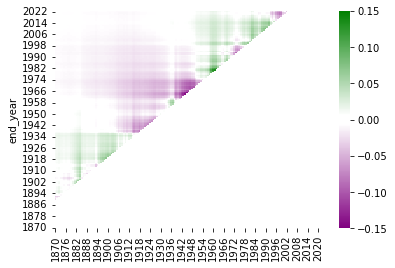

In [473]:
vmin = -0.15 # note that these were set manually after this had run once and the vmin and max had been determined
vmax = -vmin

# setting the colorbar
colors = [(0,'purple'), (0.48,'white'), (0.52,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)
sns.heatmap(trendsMean, cmap = cmap, vmin = vmin, vmax = vmax)

## 5) Calculating the universal 95% range

In [127]:
trendsUni = dict(trendsUni)

# first have to consolidate all trends by date tuples

# first start with one filled dictionary
trendsUniCons = defaultdict(list)

for key, values in trendsUni.items():
    for dates, trends in values[0].items():
        trendsUniCons[dates].append(trends)

trendsUniCons = dict(trendsUniCons)

# new dictionary
trendsUniCons2 = defaultdict(list)

# now to consolidate all lists under each date pair
for key, values in trendsUniCons.items():
    mergedList = [] # shouldn't be right here
    for lst in values:
        mergedList += lst
    trendsUniCons2[key] = (mergedList)
    
trendsUniCons2 = dict(trendsUniCons2)

# Calculating the 2.5 and 97.5 percentile
dictLowestUni, dictHighestUni = CalculateTrendPercentile(trendsUniCons2, 2.5, 97.5)

# now making a dictionary for where the observations lie in this interval
dictObsInRangeUni = defaultdict(list)

for key, value in trendsHad.items():
    if (key in list(dictLowestUni.keys())) & (key in list(dictHighestUni.keys())):
        if (value >= dictLowestUni[key]) & (value <= dictHighestUni[key]):
            dictObsInRangeUni[key] = 1
        else:
            dictObsInRangeUni[key] = 0
    else:
        dictObsInRangeUni[key] = np.nan
        
# making this into a df
dfObsInRangeUni = DictToDf(dictObsInRangeUni)

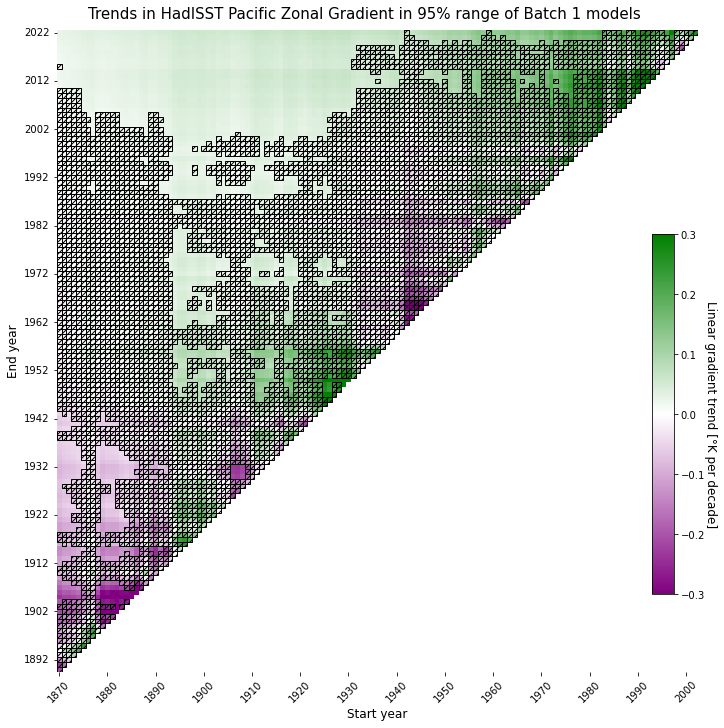

In [128]:
# plotting this
fig, ax = plt.subplots(figsize = (10,10), constrained_layout = True)
fig.suptitle('Trends in HadISST Pacific Zonal Gradient in 95% range of eight models', fontsize = 15)

vmin = -0.3
vmax = -vmin

# setting the colorbar
colors = [(0,'purple'), (0.50,'white'), (1,'green')]
cmap = mcolors.LinearSegmentedColormap.from_list('Purple_White_Green', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

ax.set_aspect('equal')
plot = sns.heatmap(trendsHadDf, cmap = cmap, ax = ax, vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, center = 0, cbar = False, norm = norm)
ax.tick_params(axis = 'x', rotation = 45)
ax.tick_params(axis = 'y', rotation = 0)
ax.set_ylabel('End year', fontsize = 12)
ax.set_xlabel('Start year', fontsize = 12)

cbarAx = fig.add_axes([0.90, 0.18, 0.03, 0.5])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('Linear gradient trend [°K per decade]', rotation = 270, labelpad = 12, fontsize = 12)

# adding the stippling with a for loop
for a, row in enumerate(dfObsInRangeUni.values):
    for b, value in enumerate(row):
        if value == 1:
            plot.add_patch(plt.Rectangle((b, a), 1, 1, fill=True, color = 'black', edgecolor=None, alpha = 0.1))

# making and changing the directory
if os.path.isdir(plotsDir):
    os.chdir(plotsDir)
else:
    os.mkdir(plotsDir)
    os.chdir(plotsDir)

fileName = 'Universal_95Range_ALL.png'

for i, fig in enumerate(plt.get_fignums()):
    plt.figure(fig)
    plt.savefig(fileName)

plt.show()


## 6) Calculating a new metric to separate out the models by performance

### Part 1: pattern correlation of the model mean and observations

In [363]:
# TEMP
models = ['CanESM5', 'MIROC6', 'GISS-E2-1-G', 'MPI-ESM1-2-LR', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'ACCESS-ESM1-5', 'CNRM-CM6-1']

In [369]:
# --------------------
# WEIGHTS
# --------------------

# calculating the trend lengths for weights based on one of the time series
model = 'MIROC6' # just picking one to get the dates
gradientMean = CalculateMMEGradient(gradientsDir, model)
trends = Trend(gradientMean).trends

# creating a dataframe of weights
# iterate through the keys of the trends and calculate the difference between them and turn that into a dataframe
dictTrendLengths = {}

for dates in trends:
    length = dates[1] - dates[0]
    
    if (length >= 20):
        dictTrendLengths[dates] = length

# creating df
dfTrendLengths = DictToDf(dictTrendLengths)

# creating weights (i.e., dividing by the whole sum) | flatten this
dfWeights = pd.Series((dfTrendLengths/dfTrendLengths.sum().sum()).values.flatten())

# --------------------
# TRENDS and CORR
# --------------------

dictCorr = {}
dictRange = {}
dictObsInRangeWeighted = {}

for model in models:
    
    gradientMean = CalculateMMEGradient(gradientsDir, model)
    trends = Trend(gradientMean).trends
    trendsDf = Trend(gradientMean).trendsDf

    trendsDfCropped = CropTrendsDf(trendsDf, 20)

    # create flattened arrays that are pandas dataframes (because they handle Nans well for correlation coefficients)
    dfModelTrendsFlat = pd.Series(trendsDfCropped.values.flatten())
    dfHadTrendsFlat = pd.Series(trendsHadDf.values.flatten())
    
    # weighting the two input models
    dfModelTrendsWeighted = dfWeights*dfModelTrendsFlat
    dfHadTrendsWeighted = dfWeights*dfHadTrendsFlat

    # CORR
    # compute corr_coeff
    corr = dfModelTrendsWeighted.corr(dfHadTrendsWeighted)
    
    # save the corr
    dictCorr[model] = corr
    
    # RANGE
    dfRangeFlat = pd.Series(dictRanges[model].values.flatten())
    dfRangeWeighted = pd.Series(dfWeights*dfRangeFlat)
    dictRange[model] = dfRangeWeighted.mean()
    
    # OBSINRANGE_weighted
    dfObsInRangeFlat = pd.Series(dictObsInRangeAll[model].values.flatten())
    dfObsInRangeWeighted = pd.Series(dfWeights*dfObsInRangeFlat)
    dictObsInRangeWeighted[model] = dfObsInRangeWeighted.mean()

{'CanESM5': 3.597226053425218e-05,
 'MIROC6': 7.264450395995561e-05,
 'GISS-E2-1-G': 6.651234893810121e-05,
 'MPI-ESM1-2-LR': 7.413974872082648e-05,
 'IPSL-CM6A-LR': 3.520971111393558e-05,
 'MIROC-ES2L': 7.396252982181058e-05,
 'ACCESS-ESM1-5': 5.5594966046230366e-05,
 'CNRM-CM6-1': 5.832280318538034e-05}

In [401]:
# now creating a master table of the values we've collected
modelSummary = pd.DataFrame(dictMembersNum.items(), columns = ['Model', 'Members'])
modelSummary = modelSummary.set_index('Model')
modelSummary['Range'] = pd.Series(dictRange)
modelSummary['Percent_In'] = pd.Series(dictPercentIn)*100
modelSummary['Weighted_Proportion_In'] = pd.Series(dictObsInRangeWeighted)*10000
modelSummary['CorrHad'] = pd.Series(dictCorr)
modelSummary['RangeByCorrHad'] = modelSummary['Range']*modelSummary['CorrHad']

In [402]:
# saving out the summary table for future use
os.chdir(statsDir)
fileName = 'ModelSummaries.csv'
modelSummary.to_csv(fileName, index = True)

In [403]:
modelSummary

,Members,Range,Percent_In,Weighted_Proportion_In,CorrHad,RangeByCorrHad
Model,,,,,,
CanESM5,65,0.000006,37.436876,0.359723,-0.355479,-2.011864e-06
MIROC6,50,0.000020,77.712939,0.726445,-0.558057,-1.115531e-05
GISS-E2-1-G,46,0.000018,73.100662,0.665123,-0.551295,-9.924631e-06
MPI-ESM1-2-LR,31,0.000016,71.462238,0.741397,-0.024156,-3.947428e-07
IPSL-CM6A-LR,32,0.000006,37.335877,0.352097,-0.146428,-8.796635e-07
MIROC-ES2L,31,0.000025,77.656829,0.739625,-0.568294,-1.413736e-05
ACCESS-ESM1-5,30,0.000009,54.988217,0.555950,-0.294088,-2.544186e-06
CNRM-CM6-1,28,0.000011,62.810010,0.583228,-0.129370,-1.399439e-06


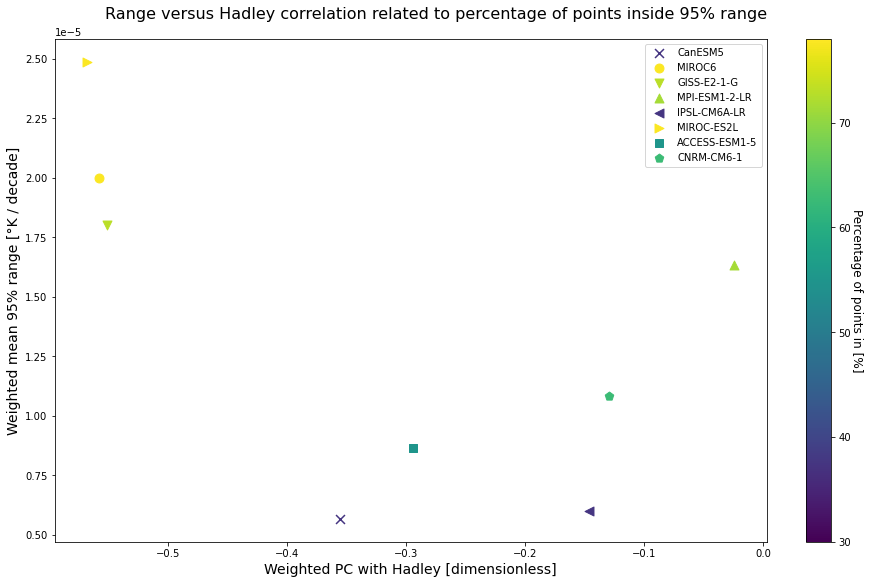

In [392]:
markers = ['x', 'o', 'v', '^', '<', '>', 's', 'p']
i = 0
norm = mcolors.Normalize(vmin = 30, vmax = 78)

fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)
fig.suptitle('Range versus Hadley correlation related to percentage of points inside 95% range', fontsize = 16)
ax.set_xlabel('Weighted PC with Hadley [dimensionless]', fontsize = 14)
ax.set_ylabel('Weighted mean 95% range [°K / decade]', fontsize = 14)

for index, value in modelSummary.iterrows():
    scatter = ax.scatter(value.CorrHad, value.Range, c = value.Percent_In, cmap = 'viridis', norm = norm, marker = markers[i], s = 80, label = index)
    i += 1

plt.legend()
colorBar = plt.colorbar(scatter)
colorBar.set_label('Percentage of points in [%]', rotation = 270, labelpad = 12, fontsize = 12)
plt.show()

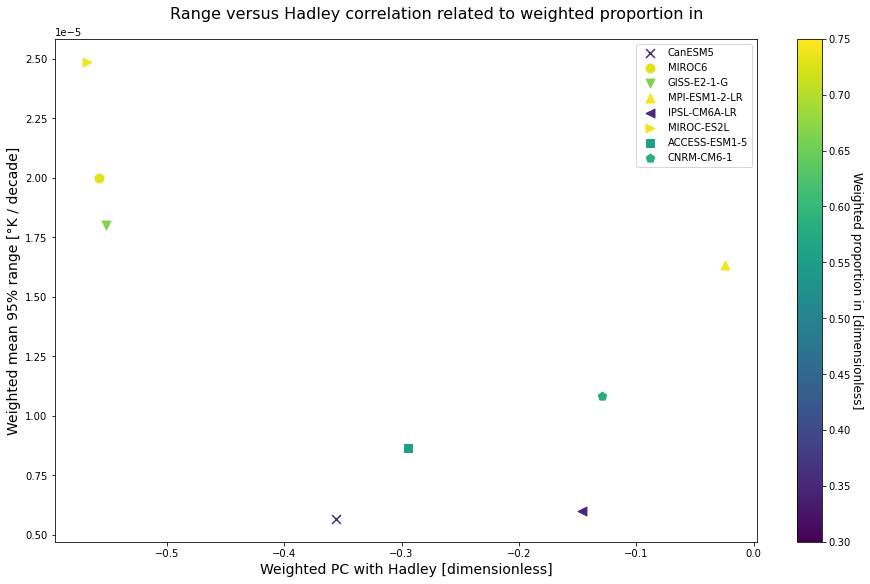

In [393]:
markers = ['x', 'o', 'v', '^', '<', '>', 's', 'p']
i = 0
norm = mcolors.Normalize(vmin = 0.3, vmax = 0.75)

fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)
fig.suptitle('Range versus Hadley correlation related to weighted proportion in', fontsize = 16)
ax.set_xlabel('Weighted PC with Hadley [dimensionless]', fontsize = 14)
ax.set_ylabel('Weighted mean 95% range [°K / decade]', fontsize = 14)

for index, value in modelSummary.iterrows():
    scatter = ax.scatter(value.CorrHad, value.Range, c = value.Weighted_Proportion_In, cmap = 'viridis', norm = norm, marker = markers[i], s = 80, label = index)
    i += 1

plt.legend()
colorBar = plt.colorbar(scatter)
colorBar.set_label('Weighted proportion in [dimensionless]', rotation = 270, labelpad = 12, fontsize = 12)
plt.show()

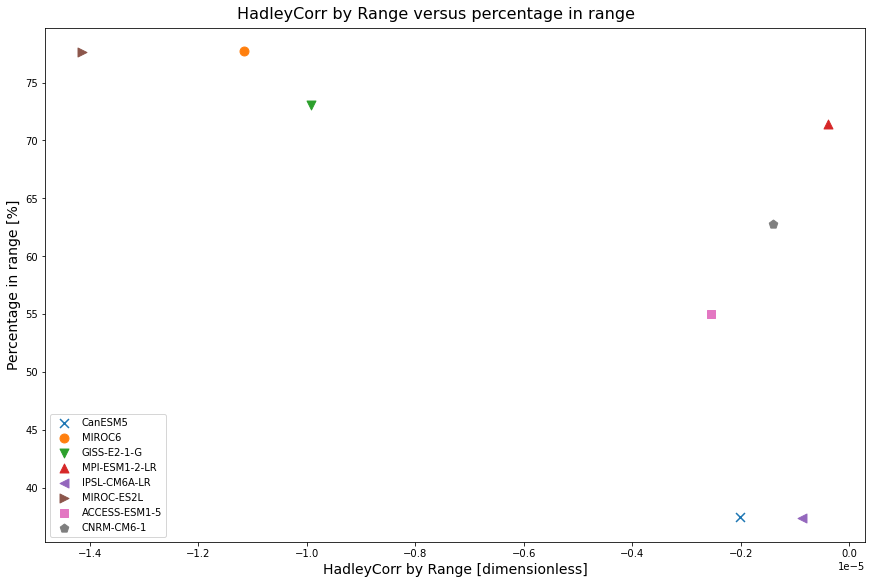

In [399]:
# trying the other figure for the combined metric
markers = ['x', 'o', 'v', '^', '<', '>', 's', 'p']
i = 0
norm = mcolors.Normalize(vmin = 30, vmax = 50)

fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)
fig.suptitle('HadleyCorr by Range versus percentage in range', fontsize = 16)
ax.set_xlabel('HadleyCorr by Range [dimensionless]', fontsize = 14)
ax.set_ylabel('Percentage in range [%]', fontsize = 14)

for index, value in modelSummary.iterrows():
    scatter = ax.scatter(value.RangeByCorrHad, value.Percent_In, marker = markers[i], s = 80, label = index)
    i += 1

plt.legend()
plt.show()

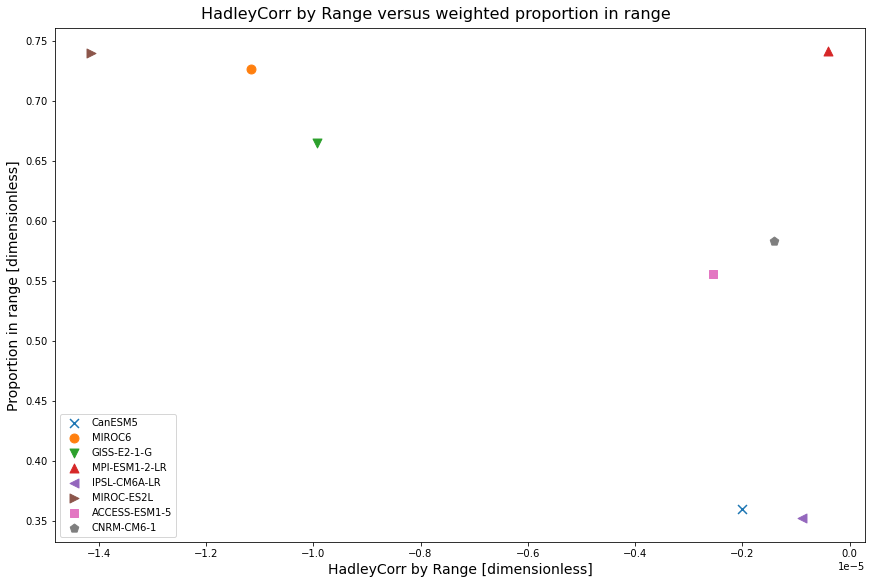

In [400]:
# trying the other figure for the combined metric
markers = ['x', 'o', 'v', '^', '<', '>', 's', 'p']
i = 0
norm = mcolors.Normalize(vmin = 30, vmax = 50)

fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)
fig.suptitle('HadleyCorr by Range versus weighted proportion in range', fontsize = 16)
ax.set_xlabel('HadleyCorr by Range [dimensionless]', fontsize = 14)
ax.set_ylabel('Proportion in range [dimensionless]', fontsize = 14)

for index, value in modelSummary.iterrows():
    scatter = ax.scatter(value.RangeByCorrHad, value.Weighted_Proportion_In, marker = markers[i], s = 80, label = index)
    i += 1

plt.legend()
plt.show()

In [356]:
modelsByRange = list(modelSummary.sort_values(by = 'Range').index)